In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from sklearn.linear_model import LinearRegression
from lib.cartpoleenv import CartPoleEnv
from lib.cartpolesystem import CartPoleSystem, Cart, Pole, StepperMotor
from lib.numerical import rk4_step

In [135]:
dt = 0.005
g = 9.81
r = 0.04456
m = 0.2167
x_max = 1.15/2

d = 0.000003

l1 = 0.115
a1 = 0.0540036985
m1 = 0.098519
d1 = d
J1 = 0.0002134646
pole1 = Pole(m1, l1, a1, d1, J1)

l2 = 0.200
a2 = 0.067341
m2 = 0.09445
d2 = d
J2 = 0.000403
pole2 = Pole(m2, l2, a2, d2, J2)

cart = Cart(m, 0.01, (-x_max, x_max), 0.1)
motor = StepperMotor(r, (-2.7, 2.7), 0.1, (-2, 2), 0.1)
poles = [
    # pole1, 
    pole2,
]
system = CartPoleSystem(cart, motor, poles, g, False)
path = "./cartpolesystems"

if system.check_equations(path):
    system.import_equations(path)
else:
    system.set_equations()
    system.export_equations(path)

In [136]:
df = pd.read_csv('data/2-3-9.csv')
print("Entries before filter: ", len(df))
df = df.dropna()
print("Entries after filter: ", len(df))
df

Entries before filter:  3984
Entries after filter:  3982


,s,d_s,theta_1,d_theta_1,u,time,T,desired_s,error_s,desired_d_s,error_d_s,desired_theta_1,error_theta_1,desired_d_theta_1,error_d_theta_1,desired_u
0,-0.440098,0.00,0.189733,0.000000,0.000000,0.000000,3.939881e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.00,-3.141593,0.000000,0.000000,0.965175,2.605009e-18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00,-3.140059,1.389475,0.000000,0.967174,3.536532e-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.00,-3.140059,0.000000,0.000000,0.968721,3.263112e-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.00,-3.140059,0.000000,0.000000,0.972836,3.263112e-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,4.085760,2.52,-2.532602,-2.838077,-57.924925,20.500142,-7.073326e-01,0.000909,-4.094371,-0.016230,-2.536230,0.008857,2.550663,-0.008383,2.567571,0.099422
3979,4.095280,2.52,-2.541806,-2.575954,-57.253449,20.505069,-6.982471e-01,0.000829,-4.103971,-0.015735,-2.535735,0.008814,2.567494,-0.008867,5.093065,0.099324
3980,4.104800,2.52,-2.558680,-5.101932,-66.296232,20.509972,-8.051572e-01,0.000752,-4.113568,-0.015242,-2.535242,0.008769,2.576653,-0.009363,3.059622,0.099123
3981,4.114320,2.52,-2.567884,-3.068985,-59.587991,20.514894,-7.238870e-01,0.000677,-4.123163,-0.014749,-2.534749,0.008721,2.595012,-0.009870,4.046492,0.098922


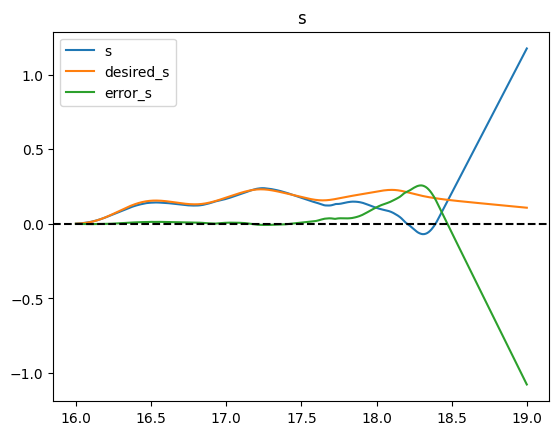

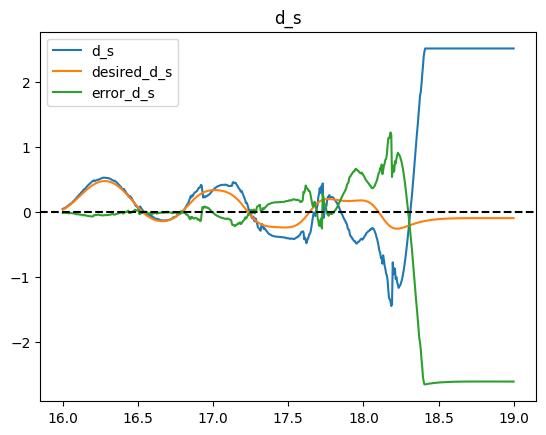

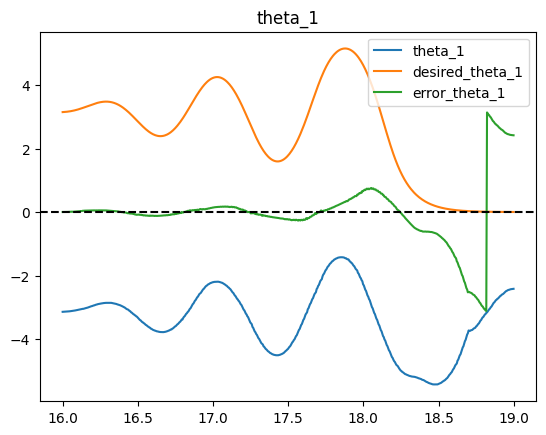

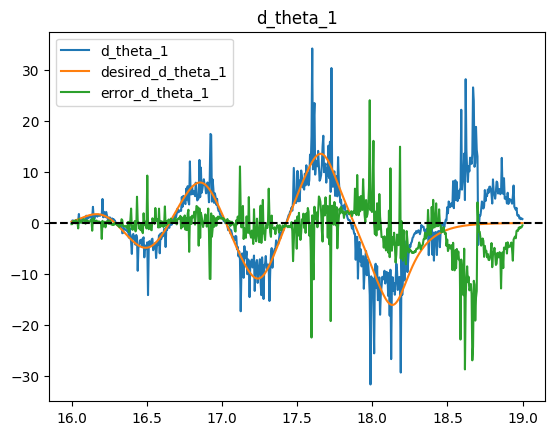

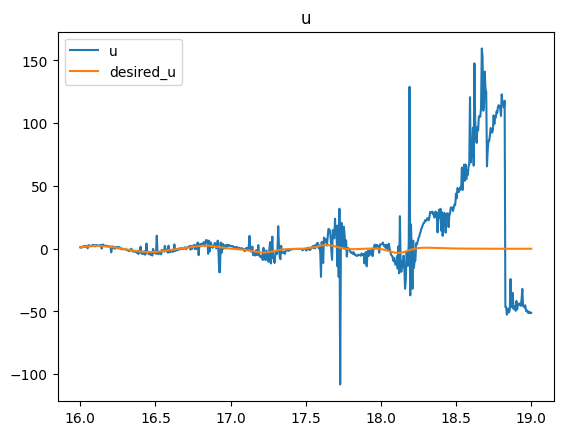

In [138]:
df = df[(df['time'] >= 16) & (df['time'] <= 19)]

time = df['time']
columns = ["s", "d_s", "theta_1", "d_theta_1", "theta_2", "d_theta_2"][:2+2*system.num_poles]
desired_columns = [f"desired_{column_name}" for column_name in columns]

for column_name in columns:
    mod_pi = column_name.startswith("theta")
    desired_column_name = f"desired_{column_name}"
    error_column_name = f"error_{column_name}"
    column = df[column_name].to_numpy()
    desired_column = df[desired_column_name].to_numpy()
    error_column = df[error_column_name].to_numpy()
    if mod_pi:
        column = np.unwrap(column)
        desired_column = np.unwrap(desired_column)

    plt.plot(time, column, label=column_name)
    plt.plot(time, desired_column, label=desired_column_name)
    plt.plot(time, error_column, label=error_column_name)
    plt.axhline(0, color='black', linestyle='--')
    plt.legend()
    plt.title(column_name)
    plt.show()

plt.title("u")
plt.plot(time, df['u'], label='u')
plt.plot(time, df['desired_u'], label='desired_u')
plt.legend()

In [73]:
states = np.array(df[columns])
desired_states = np.array(df[desired_columns])

last_update = perf_counter()
env = CartPoleEnv(system, dt, rk4_step)
for state, desired_state in zip(states, desired_states):
    env.render(state, desired_state)
    while perf_counter() - last_update < dt*10:
        pass
    last_update = perf_counter()
env.close()

AttributeError: 'NoneType' object has no attribute 'fill'

In [ ]:
import sympy as sp
import sympy.physics.mechanics as me

In [ ]:
s_sx = me.dynamicsymbols("s")
d_s_sx = sp.diff(s_sx)
dd_s_sx = sp.diff(d_s_sx)
thetas_sx = [me.dynamicsymbols(f"theta{i+1}") for i in range(system.num_poles)] #type: ignore
d_thetas_sx = [sp.diff(theta_sx) for theta_sx in thetas_sx]
dd_thetas_sx = [sp.diff(d_theta_sx) for d_theta_sx in d_thetas_sx]
tau_sx = sp.symbols("tau")

pole_pc1s = []
pole_pc2s = []
for i, (theta_sx, a) in enumerate(zip(thetas_sx, system.pole_as)):
    prev_1 = 0
    prev_2 = 0
    for prev_l, prev_theta in list(zip(system.pole_ls, thetas_sx))[:i]:
        prev_1 += -prev_l*sp.sin(prev_theta)
        prev_2 += prev_l*sp.cos(prev_theta)
    pole_pc1s.append(s_sx-a*sp.sin(theta_sx)+prev_1)
    pole_pc2s.append(a*sp.cos(theta_sx)+prev_2)

T = 1/2*system.m_c*d_s**2 #type: ignore
for m, pc1, pc2, J, d_theta in zip(system.pole_ms, pole_pc1s, pole_pc2s, system.pole_Js, d_thetas_sx):
    d_pc1 = sp.diff(pc1)
    d_pc2 = sp.diff(pc2)
    T += 1/2*m*(d_pc1**2 + d_pc2**2) + 1/2*J*d_theta**2 #type: ignore
    
V = 0   
for m, pc2 in zip(system.pole_ms, pole_pc2s):
    V += system.g*m*pc2

R = 0
prev_w = 0
for d, d_theta in zip(self.pole_ds, d_thetas):
    R += 1/2*d*(d_theta-prev_w)**2 #type: ignore
    prev_w = d_theta

eqs = []
L = T-V
lh = sp.diff(sp.diff(L, d_s)) - sp.diff(L, s) + sp.diff(R, d_s) #type: ignore
rh = tau
eqs = [lh-rh]
for theta, d_theta in zip(thetas, d_thetas):
    L = T-V
    lh = sp.diff(sp.diff(L, d_theta)) - sp.diff(L, theta) + sp.diff(R, d_theta) #type: ignore
    rh = 0
    eqs.append(lh-rh)

sp_vars = [s, d_s] + [item for pair in zip(thetas, d_thetas) for item in pair] + [dd_s] + dd_thetas
sols = sp.solve(eqs, dd_thetas+[tau])
sp_sols = [sp.simplify(sols[dd_theta]) for dd_theta in dd_thetas] + [sp.simplify(sols[tau])]

_s, _d_s, _dd_s = sp.symbols("s, d_s, dd_s")
_thetas = [sp.symbols(f"theta{i+1}") for i in range(self.num_poles)]
_d_thetas = [sp.symbols(f"d_theta{i+1}") for i in range(self.num_poles)]
_dd_thetas = [sp.symbols(f"dd_theta{i+1}") for i in range(self.num_poles)]
self.sp_vars = [_s, _d_s] + [item for pair in zip(_thetas, _d_thetas) for item in pair] + [_dd_s] + _dd_thetas
subs_dict = dict(zip(sp_vars, self.sp_vars))
self.sp_sols = [sol.subs(subs_dict) for sol in sp_sols]

NameError: name 'd_s' is not defined

In [ ]:
d_s = df['d_s'].to_numpy()[1:-1]
theta_1 = df['theta_1'].to_numpy()[1:-1]
d_theta_1 = df['d_theta_1'].to_numpy()[1:-1]
dd_theta_1 = df['d_theta_1'].diff().to_numpy()[1:-1]/dt

X = d_theta_1
dd_s = df['u'].to_numpy()[1:-1]
y = m1*l1/2*(g*np.sin(theta_1)-dd_s*np.cos(theta_1)-7*l1/2/3*dd_theta_1)

model = LinearRegression().fit(X.reshape(-1, 1), y)
print(model.coef_, model.intercept_)

[-0.00244534] -0.000351615042869892


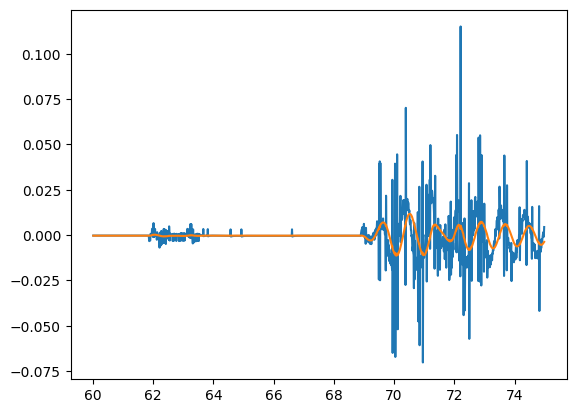

In [ ]:
y_calc = model.predict(X.reshape(-1, 1))
time = time[1:-1]
plt.plot(time, y, label='y')
plt.plot(time, y_calc, label='y_calc')